In [1]:
# Load packages
import sys
import os
import glob

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats 
from scipy.optimize import curve_fit 

import FunctionsP6 as fc

import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import dask.config as dc
dc.set(**{'array.slicing.split_large_chunks': True});

import warnings
warnings.filterwarnings('ignore')

dpi=200

In [2]:
savepath = os.getcwd() + '/Figures_GSAT-AMOC/'

In [64]:
'''
We load the data that is prepared in 'M2_DataPrep'
'''
# GSAT, zostoga observations (1900 - 2005) merged with AR6 ranges for all scenarios (2005 - 2100) 
df_low = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_low_perc.csv').set_index('Date')
df_mid = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_mid_perc.csv').set_index('Date')
df_hig = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_hig_perc.csv').set_index('Date')

# CMIP5 and CMIP6 data (1900 - 2100)
CMIP5ds = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP5.nc')
CMIP6ds = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP6.nc')

CMIP5ds_LF = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP5_LF_25.nc')
CMIP6ds_LF = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP6_LF_25.nc')

# DSL budgets / reanalysis (ora20c)
df_dsl_b1 = pd.read_csv(os.getcwd() + '/data_processed/DSL_b1.csv' ).set_index('time') # (1979 - 2018)
df_dsl_b2 = pd.read_csv(os.getcwd() + '/data_processed/DSL_b2.csv' ).set_index('time') # (1950 - 2020)

# Reanalysis (1905 - 2005) (1990-1994 and 2006-2009 is nan)
DSL_ora20c = xr.open_mfdataset(os.getcwd()+'/data_processed/DSL_ora20c.nc') # 1900 - 2022


'''
Change the reference period to 1900,1950 (or any other period between 1900 - 2009)
'''
ref_st, ref_end = 1900,1950

for dfs in [df_low, df_mid, df_hig]:
    dfs.iloc[:,0:3] = dfs.iloc[:,0:3] - dfs.loc[ref_st:ref_end].mean()[1]
    dfs.iloc[:,3:6] = dfs.iloc[:,3:6] - dfs.loc[ref_st:ref_end].mean()[4]

CMIP5ds = CMIP5ds - CMIP5ds.sel(time=slice(ref_st,ref_end)).mean(dim='time')
CMIP6ds = CMIP6ds - CMIP6ds.sel(time=slice(ref_st,ref_end)).mean(dim='time')

CMIP5ds_LF = CMIP5ds_LF - CMIP5ds_LF.sel(time=slice(ref_st,ref_end)).mean(dim='time')
CMIP6ds_LF = CMIP6ds_LF - CMIP6ds_LF.sel(time=slice(ref_st,ref_end)).mean(dim='time')

DSL_ora20c = DSL_ora20c - DSL_ora20c.sel(year=slice(ref_st,ref_end)).mean(dim=['year','member'])


## Functions

In [8]:
def select_models(ds, varx1, varx2, vary, check):
    '''
    Check is either 'model', or 'scenario'
    Find models for which all three variables (zos, gsat, zostoga) are available
    Input is dataset CMIP5ds or CMIP6ds. 
    If you want to check the scenarios per model, already select the model in the input: eg. CMIP5ds.sel(model=mod)
    It returns the model/sce names of models/sces that have data for all three variables and returns the new dataset.
    '''
    
    x1 = ds[varx1].dropna(check,'all')[check].values
    x2 = ds[varx2].dropna(check,'all')[check].values
    y = ds[vary].dropna(check,'all')[check].values
        
    check_list = np.sort(list(set(x1)&set(x2)&set(y)))
    
    if check == 'model':
        ds_new = ds.sel(model=check_list)
        
    elif check == 'scenario':
        ds_new = ds.sel(scenario=check_list)
    
    return check_list, ds_new

In [9]:
mods5_GS_zos, mods5_GS_AMOC_zos, missing_mods5 = [],[],[]
mods6_GS_zos, mods6_GS_AMOC_zos, missing_mods6 = [],[],[]
dfs5=[]
for scess in ['ssp126','ssp245','ssp585']:
    ds5 = CMIP5ds_LF.sel(scenario=scess)
    m_GS_zos = select_models(ds5, 'GSAT', 'GSAT', 'zos','model')[0]
    m_GS_zos_AMOC = select_models(ds5, 'GSAT', 'AMOC26', 'zos','model')[0]

    mods5_GS_zos.append(m_GS_zos)
    mods5_GS_AMOC_zos.append(m_GS_zos_AMOC)
    missing_mods5.append(list(set(m_GS_zos).difference(m_GS_zos_AMOC)))

for scess in ['ssp126','ssp245','ssp585']:

    ds6 = CMIP6ds_LF.sel(scenario=scess)
    m_GS_zos = select_models(ds6, 'GSAT', 'GSAT', 'zos','model')[0]
    m_GS_zos_AMOC = select_models(ds6, 'GSAT', 'AMOC26', 'zos','model')[0]

    mods6_GS_zos.append(m_GS_zos)
    mods6_GS_AMOC_zos.append(m_GS_zos_AMOC)
    missing_mods6.append(list(set(m_GS_zos).difference(m_GS_zos_AMOC)))


In [10]:
#%% Multi-linear regression
def lin_reg_multi(varx, vary):
    regr = linear_model.LinearRegression()

    varx = varx.dropna()
    vary = vary.dropna()

    regr.fit(varx, vary)
    
    vary_pred = regr.predict(varx)

    mse = mean_squared_error(vary, vary_pred)
    r2 = r2_score(vary, vary_pred)
    slope = regr.coef_
    intercept = regr.intercept_
    
    return vary_pred, mse, r2, slope, intercept

In [11]:
def multi_lin_fit(ds, varx1, varx2, mip):
    
    ds_new = select_models(ds, varx1, varx2 ,'zos','model')[1]
    
    nan_array_sce = np.ones(95)*np.nan
    mods, sces = [],[]
    dfs = []
    mses, r2s, slope_varx1, slope_varx2, intercepts = [],[],[],[],[]
    
    for j, mod in enumerate(ds_new.model.values):
        sces_in_mod = select_models(ds_new.sel(model=mod), varx1, varx2, 'zos', 'scenario')[0]
        ds_mod = ds_new.sel(model=mod)
        mods.append(mod)           # append model name
        sces.append(sces_in_mod)   # append scenarios available for this model
        
        if mip == 'CMIP5': 
            end_hist = 2005
            nan_num = 95
        elif mip == 'CMIP6':
            end_hist = 2014
            nan_num = 86
                
        ds_hist = ds_mod.sel(time=slice(1900,end_hist),scenario=sces_in_mod[0])  # select historical period for one sce
        ds_sces = ds_mod.sel(time=slice(end_hist,2100))                          # select future period for all sces

        DSL_mod, varx1_mod, varx2_mod = ds_hist.zos.values, ds_hist[varx1].values, ds_hist[varx2].values        
        
            
        for sce in ['ssp126','ssp245','ssp585']:        
            ds_sce = ds_sces.sel(scenario=sce)
            
            zos = ds_sce.zos.values
            varx1_list = ds_sce[varx1].values
            varx2_list = ds_sce[varx2].values
            
            if(np.isnan(zos).any()) or (np.isnan(varx1_list).any()) or (np.isnan(varx2_list).any()):
                DSL_mod = np.append(DSL_mod, np.ones(nan_num)*np.nan)
                varx1_mod = np.append(varx1_mod, np.ones(nan_num)*np.nan)
                varx2_mod = np.append(varx2_mod, np.ones(nan_num)*np.nan)
            else:
                DSL_mod = np.append(DSL_mod, zos)
                varx1_mod = np.append(varx1_mod, varx1_list)
                varx2_mod = np.append(varx2_mod, varx2_list)
            
        # Store total data in dataframe for each model
        d = {'DSL': DSL_mod, 'varx1': varx1_mod, 'varx2': varx2_mod}
        df = pd.DataFrame(data=d)    
        dfs.append(df)
         
        # Compute regression for this model    
        X = df[['varx1','varx2']] 
        Y = df[['DSL']] 
        
        #print(df)
        linreg = lin_reg_multi(X,Y)
        mse, r2, slope, intercept = linreg[1], linreg[2], linreg[3], linreg[4]
        
        mses.append(mse)
        r2s.append(r2)
        slope_varx1.append(slope[0][0])
        slope_varx2.append(slope[0][1])
        intercepts.append(intercept[0])
    
        
    # Construct dataframe to store parameter values
    d = {'model': mods, 'sces':sces, 'r2-score':r2s,'alpha': intercepts, 'beta1':slope_varx1, 'beta2': slope_varx2, 'mse': mses}
    df_params = pd.DataFrame(data=d).set_index('model')
    
            
    return dfs, mods, sces, df_params

In [65]:
#=========================================================
#%% Function to plot individual models DSL and fits
#=========================================================
def checks_3(df, params, mip, mod_list, sce_list, varx1_name, varx2_name,saveplot=None):
    
    # INDIVIDUAL MODELS
    nrows = int(np.round(len(mod_list)/4+.499))
    if mip == 'CMIP5':
        #nrows = 3
        ncols = 4
        fig, ax = plt.subplots(int(nrows), ncols,figsize=(20,10),sharex=True,sharey=True)

    elif mip == 'CMIP6': 
        #nrows = 5
        ncols = 4
        fig, ax = plt.subplots(int(nrows), ncols,figsize=(20,14),sharex=True,sharey=True)

    ax = ax.ravel()
    
    m_DSLs, DSL_fits = [],[]
    alphs, bets1, bets2, mses = [],[],[],[]
    m_x1s, m_x2s = [],[]
    for i in range(int(len(mod_list))):
        df_mod, sces_mod, mod_name = df[i], sce_list[i], mod_list[i]
        pars = params.loc[mod_name]
        
        DSL_fit = pars['alpha'] + pars['beta1']*df_mod['varx1']+ pars['beta2']*df_mod['varx2']
        
        nan_index = np.argwhere(np.isnan(DSL_fit.values))
        alph = np.ones([len(df_mod['varx1'])])*pars['alpha']
        alph[nan_index] = np.nan # fix this that alpha is NaN for scenario with no data
        
        a = pars['alpha']
        b1 = pars['beta1']
        b2 = pars['beta2']
        
        bet1 = pars['beta1']*df_mod['varx1']
        bet2 = pars['beta2']*df_mod['varx2']
        r2 = pars['r2-score']
        mse = pars['mse']
        
        m_DSLs.append(df_mod['DSL'])
        m_x1s.append(df_mod['varx1'])
        m_x2s.append(df_mod['varx2'])

        DSL_fits.append(DSL_fit)
        alphs.append(alph)
        bets1.append(bet1)
        bets2.append(bet2)
        mses.append(mse)
        
        # Plot composition for each model separately
        ax[i].plot(df_mod['DSL'], label='CMIP Data')
        ax[i].plot(DSL_fit, c='r',label='Regression Model')
        ax[i].plot(alph, c='g',label=r'$\alpha$')
        ax[i].plot(bet1, c='k',label=r'$\beta_1 \times$'f'{varx1_name}')
        ax[i].plot(bet2, c='orange',label=r'$\beta_2 \times$'f'AMOC')
      
        
        if i % ncols == 0:
            ax[i].set_ylabel('ODSL anomaly (cm)', fontsize = 15)
        
        ax[i].tick_params(axis='x', labelsize=14)
        ax[i].tick_params(axis='y', labelsize=15)
    
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        textstr = r'$\alpha$' f' = {a:.2f} \n' r'$\beta_1$' f' = {b1:.2f} \n' r'$\beta_2$' f' = {b2:.2f} '

        if i == 0:
            ax[i].text(0.72, 0.95, textstr, transform=ax[i].transAxes, fontsize=14, verticalalignment='top', bbox=props)
            ax[i].legend(loc='upper left',fontsize=14)

        else:
            ax[i].text(0.05, 0.95, textstr, transform=ax[i].transAxes, fontsize=14, verticalalignment='top', bbox=props)
        ax[i].set_ylim([-10,50])
        ax[i].set_title(f'{mod_name} \n 'r'R$^2$'f'-score: {r2:.2f}, RMSE: {mse:.2f} cm', fontsize=16)
        ax[i].grid(True, alpha=0.3)
        
        if mip == 'CMIP5':
            ax[i].set_xticks([0, 105, 200,295], ["Historic", "RCP2.6", "RCP4.5",'RCP8.5'],  horizontalalignment='left')

        elif mip == 'CMIP6':
            ax[i].set_xticks([0, 114, 200,286], ["Historic", "SSP1-2.6", "SSP2-4.5",'SSP5-8.5'],  horizontalalignment='left')


    for j in range(len(mod_list), ncols*nrows):
        ax[j].axis("off")
    
    for j in range(len(mod_list)-ncols, len(mod_list)):
        if mip == 'CMIP5':
            ax[j].xaxis.set_tick_params(labelbottom=True, labelcolor="k")
            ax[j].set_xlabel('Time', fontsize=15)
        if mip == 'CMIP6':
            ax[j].xaxis.set_tick_params(labelbottom=True, labelcolor="k")
            ax[j].set_xlabel('Time', fontsize=15)
            
    if saveplot == True:
        fig.tight_layout()
        fig.savefig(savepath+f'Regression_singlemodels_{mip}_{varx1_name}-{varx2_name}.pdf',dpi=dpi) 
    
    # ENSEMBLE AVERAGE
    fig, ax = plt.subplots(1,1,figsize=(9.5,6))
    ax.plot(np.nanmean(m_DSLs,axis=0),lw=2,label='CMIP data')
    ax.plot(np.nanmean(alphs,axis=0), c='g',lw=2,label=r'$\alpha$')
    ax.plot(np.nanmean(bets1,axis=0), c='k',lw=2,label=r'$\beta_1 \times$'f'{varx1_name}')
    ax.plot(np.nanmean(bets2,axis=0),c='orange',lw=2,label=r'$\beta_2 \times$'f'AMOC')
    ax.plot(np.nanmean(DSL_fits,axis=0),c='r',lw=2,label='Regression Model')

    #ax.plot(np.nanmean(pars['alpha'])+np.nanmean(pars['beta1'])*np.nanmean(m_x1s,axis=0)+np.nanmean(pars['beta2'])*np.nanmean(m_x2s,axis=0),c='purple',lw=3)
    
    ax.tick_params(axis='x', labelsize=11.5)
    ax.tick_params(axis='y', labelsize=15)
    
    if mip == 'CMIP5':
        ax.set_xticks([0, 105, 200,295], ["Historic (1900 - 2005)", "RCP2.6 (2005 - 2100)", "RCP4.5 (2005 - 2100)",'RCP8.5 (2005 - 2100)'],  horizontalalignment='left')
    elif mip == 'CMIP6':
        ax.set_xticks([0, 114, 200,286], ["Historic (1900 - 2014)", "SSP1-2.6 (2014 - 2100)", "SSP2-4.5(2014 - 2100)",'SSP5-8.5 (2014 - 2100)'],  horizontalalignment='left')

    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylabel('ODSL change (cm)', fontsize = 16)
    if mip == 'CMIP5':
        ax.set_xlim([0,390])
    elif mip =='CMIP6':
        ax.set_xlim([0,372])
    ax.set_ylim([-10,40])
    ax.axvspan(0, 50, alpha=0.1, color='grey')
    
    ax.set_title(f'{mip} ensemble average \n Average RMSE: {np.nanmean(mses):.2f} cm', fontsize=17)

    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left',fontsize=16)
    
    if saveplot == True:
        fig.tight_layout()
        fig.savefig(savepath+f'Regression_ensembles_{mip}_{varx1_name}-{varx2_name}.pdf',dpi=dpi) 

In [77]:
def plot_params2(CMIP5_params, CMIP6_params, varx1_name, varx2_name, titlestr, saveplots=None):
    labs = ['CMIP5','CMIP6']
    colors = ['b','r']

    # Frequency Histogram parameter values
    fig, ax = plt.subplots(1,2,figsize=(12,4),sharey=True)
    fig.subplots_adjust(wspace=1/9)

    nbins=10
        
    if varx2_name == 'zostoga':
        wb1,wb2 = 1,0.2
        un = ''
        ax[1].set_xlim([-1,2])

    elif varx2_name == 'AMOC26' or varx2_name=='AMOC35':
        wb1,wb2 = 1,1
        un = 'cm/Sv'
        #ax[1].set_xlim([-8,4])

    for i, pars in enumerate([CMIP5_params, CMIP6_params]):
        meanbet1 = pars['beta1'].mean()  
        meanbet2 = pars['beta2'].mean()   

        H1 = ax[0].hist(pars['beta1'],bins=np.arange(np.round(min(pars['beta1']))-1, max(pars['beta1']) + wb1, wb1),alpha=0.2,color=colors[i],label=f'{labs[i]}')
        H2 = ax[1].hist(pars['beta2'],bins=np.arange(np.round(min(pars['beta2']))-1, max(pars['beta2']) + wb2, wb2),alpha=0.2,color=colors[i],label=f'{labs[i]}')

        M1 = ax[0].axvline(meanbet1,c=colors[i],ls='dashed',lw=2,label=f'Average {labs[i]}')
        M2 = ax[1].axvline(meanbet2,c=colors[i],ls='dashed',lw=2,label=f'Average {labs[i]}')

    ax[0].set_xlim([-6,8])

    for axs in ax:
        axs.set_ylim([0,8])
        axs.grid(True,alpha=0.3)
        axs.tick_params(axis='both', labelsize=14)
    
    ax[0].set_ylabel('Frequency',fontsize=14)
    ax[0].set_xlabel(r'$\beta_1$ (cm/$\degree$C)',fontsize=14)
    ax[1].set_xlabel(r'$\beta_2$' f' ({un})',fontsize=14)
    ax[0].legend(loc='upper left',fontsize=14)
    
    fig.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                        wspace=0.5)
    fig.suptitle(titlestr, fontsize=16,y=0.93)
   

    fig.tight_layout()
    if saveplots==True:
        fig.savefig(savepath+f'Parameters_Hist_{varx1_name}-{varx2_name}.pdf',dpi=dpi)
        
        
        
    # Scatter plot parameter values
    fig, ax = plt.subplots(1,1,figsize=(3,3))

    for i, pars in enumerate([CMIP5_params, CMIP6_params]):
        ax.scatter(pars['beta1'], pars['beta2'], nbins,alpha=0.8,c=colors[i],label=labs[i])

    ax.legend()
    ax.set_xlim([-4,8])
    ax.set_ylim([-8,4])
    ax.set_xlabel(r'$\beta_1$ (cm/$\degree$C)')
    ax.set_ylabel(r'$\beta_2$ (cm/Sv)')
    ax.grid(True,alpha=0.3)
    
    fig.tight_layout()
    
    if saveplots==True:
        fig.savefig(savepath+f'Parameters_Scatter_{varx1_name}-{varx2_name}.pdf',dpi=dpi)
        

### Functions - distributions etc.

In [78]:
def compute_normaldistr_ensemble(ds, sce, varx1, varx2, samples):
    
    mods = select_models(ds.sel(scenario=sce), varx1, varx2, 'zos', 'model')[0]
    ds = select_models(ds.sel(scenario=sce), varx1, varx2, 'zos', 'model')[1]
    
    time = np.arange(1900,2101,1)
    ds = ds.sel(time=slice(1900,2101))

    x1s = ds[varx1].values
    x2s = ds[varx2].values

    mus1 = np.mean(x1s,axis=0)
    sigmas1 = np.std(x1s,axis=0)
    mus2 = np.mean(x2s,axis=0)
    sigmas2 = np.std(x2s,axis=0)
    
    distr_varx1 = np.zeros([len(mus1), samples])
    distr_varx2 = np.zeros([len(mus2), samples])
    
    # Loop over the time steps
    for i in range(len(mus1)):
        distr_varx1[i] = np.random.normal(mus1[i], sigmas1[i], samples)
        distr_varx2[i] = np.random.normal(mus2[i], sigmas2[i], samples)
        
    return distr_varx1, distr_varx2

In [79]:
func_cdf = stats.weibull_min # stats.gamma, stats.weibull_min , stats.skewnorm, stats.genextreme, stats.lognorm
#pc = np.array([5,50,95])*0.01

def range_to_dist(df, var, n, st_yr, end_yr):
    
    def func(x, a, scale):
        return func_cdf.cdf(x, a, iloc, scale)

    mus = []
    stds = []
    distrs = []

    for i in np.arange(st_yr, end_yr):
        col = i
        
        if var == 'x1':
            data_sel = df.loc[col][0:3].values + np.array([50])
            pc = np.array([5,50,95])*0.01
        elif var == 'x2':
            data_sel = df.loc[col][3:6].values + np.array([50])
            pc = np.array([5,50,95])*0.01
        elif var == 'ensembles_x1':
            data_sel = df.loc[col][0:7] + np.array([50])
            pc = np.array([5,17,35,50,65,83,95])*0.01
        elif var == 'ensembles_x2':
            data_sel = df.loc[col][7:14] + np.array([50])
            pc = np.array([5,17,35,50,65,83,95])*0.01
        
        iloc = data_sel[0]-0.05
        popt, pcov = curve_fit(func, data_sel, pc)
        err = np.square(func(data_sel.astype(float), popt[0], popt[1]) - pc).mean()
    
    
        # Calculate mu and sigma for probability function
        mu = func_cdf.mean(popt[0], iloc, popt[1])
        sigma = func_cdf.std(popt[0], iloc, popt[1])
    
        mus.append(mu) 
        stds.append(sigma)
    
        mu_new = np.log(mu**2/np.sqrt(mu**2+sigma**2))
        sigma_new = np.sqrt(np.log(1+(sigma**2/mu**2)))
    
        # Sample n values from distribution and store in array
        distr = np.random.lognormal(mu_new, sigma_new, n)
        distr = np.sort(distr) - np.array([50])
        
        # Save distribution to array
        distrs.append(distr)
                  
    return distrs


def range_to_dist_obs(df, var, n, st_yr, end_yr):
    '''
    INPUT:
        - df: dataframe as above
        - var: either 'GSAT' or 'zostoga'
        - pc: percentiles: ea [5, 50, 95]
        - n: number of samples you want to generate
    OUTPUT:
        - random distribution with n values
    '''
    def func(x, a, scale):
        return func_cdf.cdf(x, a, iloc, scale)

    distrs = []
    func_cdf = stats.lognorm
        
    for i in range(st_yr,end_yr+1):
        yr = i
        if var == 'obs_GS':
            data_sel = np.sort(df.loc[yr][0:3]) + np.array([50])
            pc = np.array([2.5,50,97.5])*0.01
            
        elif var == 'obs_zt':
            data_sel = np.sort(df.loc[yr][3:6]) + np.array([50])
            pc = np.array([5,50,95])*0.01
        
        iloc = data_sel[0]-0.05
        popt, pcov = curve_fit(func, data_sel, pc)
        err = np.square(func(data_sel.astype(float), popt[0], popt[1]) - pc).mean()
    
        # Calculate mean and std for probability function
        mean = func_cdf.mean(popt[0], iloc, popt[1])
        std = func_cdf.std(popt[0], iloc, popt[1])
        
        # Translate to mu and sigma
        mu = np.log(mean**2/np.sqrt(mean**2+std**2))
        sigma = np.sqrt(np.log(1+(std**2/mean**2)))
        
        # Sample n values from distribution and store in array
        distr = np.random.lognormal(mu, sigma, n)
        distr = np.sort(distr) - np.array([50])
        
        # Save distribution to array
        distrs.append(distr)
    
    return distrs


## Plots regression models

In [80]:
## Choose the regressors and the filter
data_C5, data_C6 = CMIP5ds_LF.sel(time=slice(1900,2101)), CMIP6ds_LF.sel(time=slice(1900,2101))

varx1_ch = 'GSAT'
varx2_ch = 'AMOC26'

### CMIP5

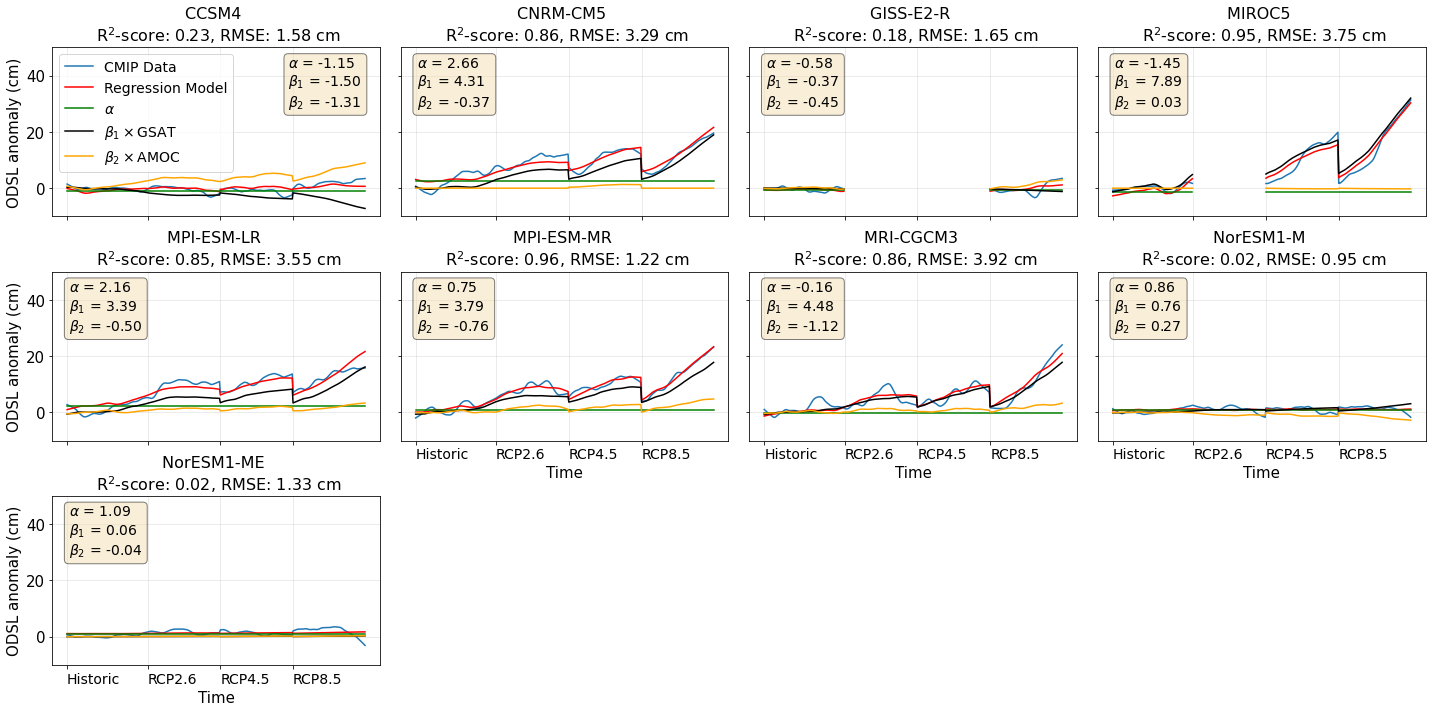

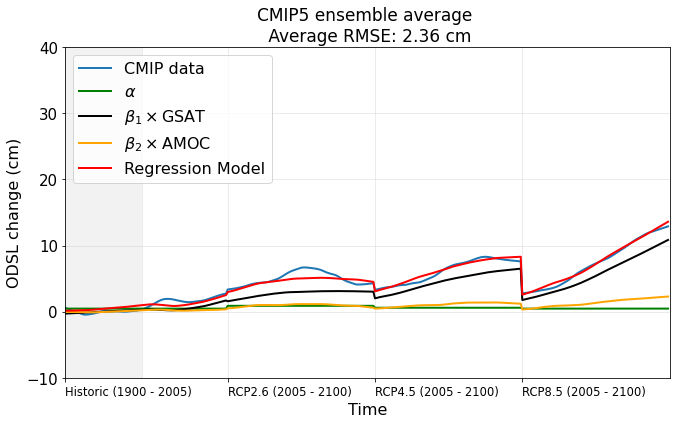

In [68]:
CMIP5_data, mods5, sces5, CMIP5_params = multi_lin_fit(data_C5, varx1_ch, varx2_ch,'CMIP5')
checks_3(CMIP5_data, CMIP5_params, 'CMIP5', mods5, sces5, varx1_ch, varx2_ch, True)

### CMIP6

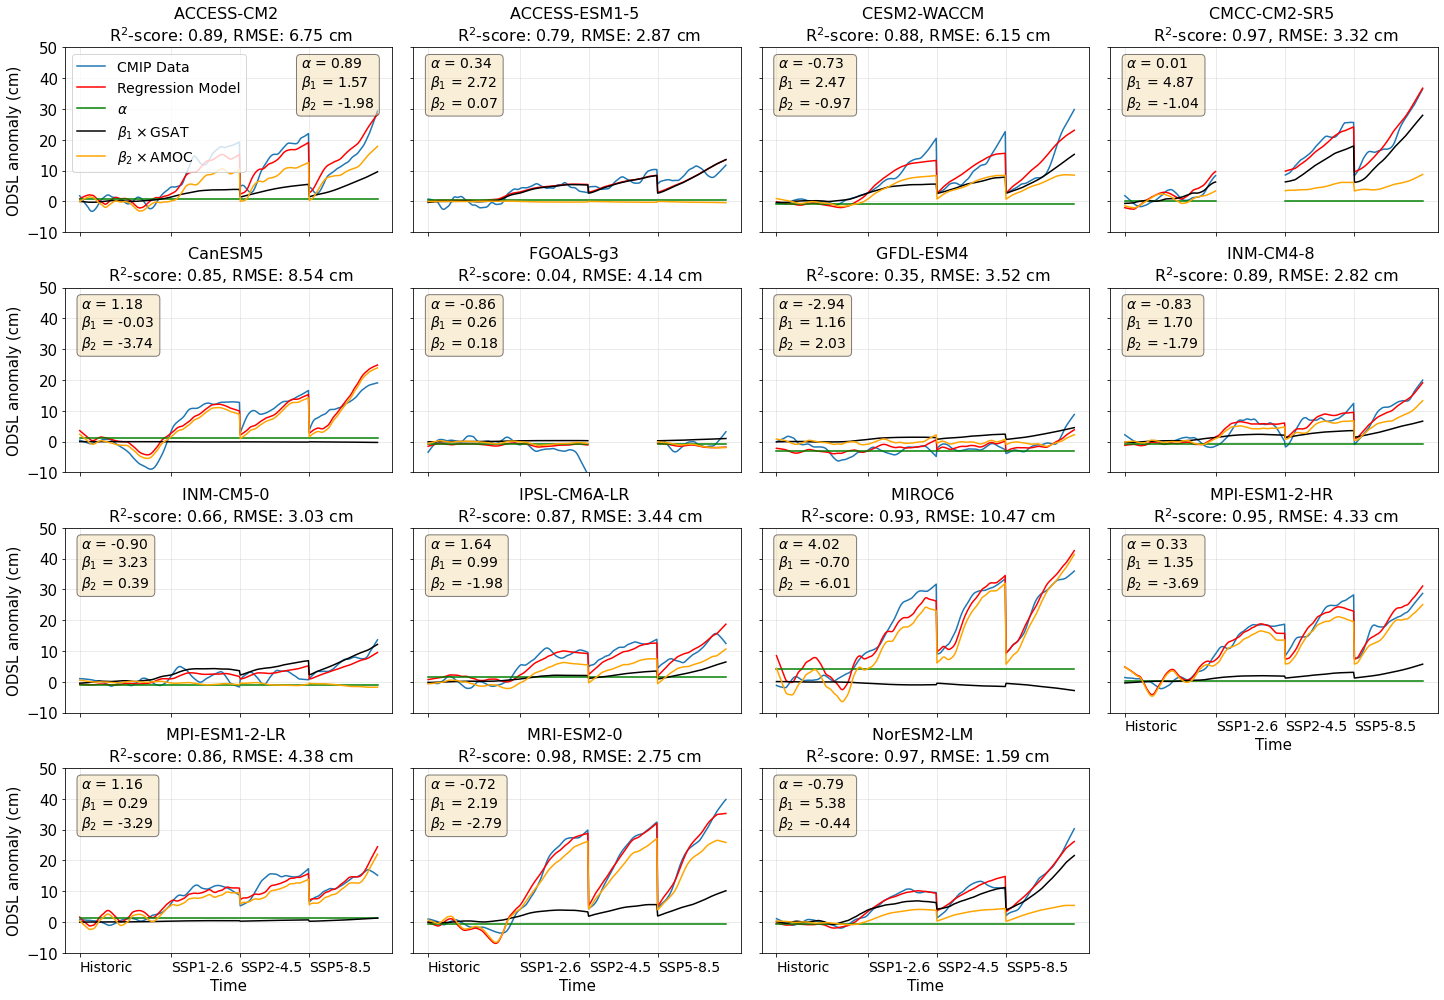

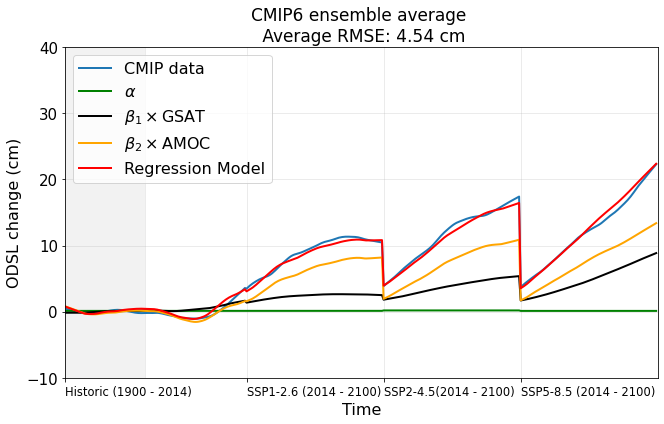

In [69]:
CMIP6_data, mods6, sces6, CMIP6_params = multi_lin_fit(data_C6, varx1_ch, varx2_ch,'CMIP6')
checks_3(CMIP6_data, CMIP6_params, 'CMIP6', mods6, sces6, varx1_ch, varx2_ch, True)

In [73]:
# Plot parameter values
print(f'Available models for CMIP5: {len(CMIP5_params)}')
print(f'Available models for CMIP6: {len(CMIP6_params)}')

#plot_params(CMIP5_params, CMIP6_params, varx1_ch, varx2_ch)

Available models for CMIP5: 9
Available models for CMIP6: 15


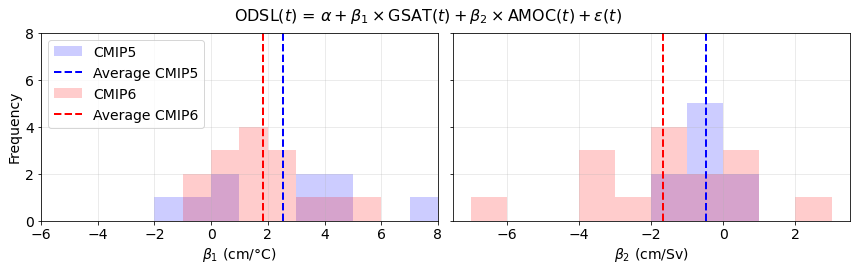

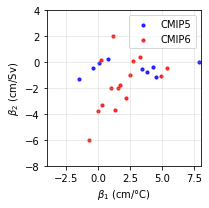

In [76]:
titlestring = 'ODSL'r'$(t)$ = $\alpha + \beta_1 \times$' 'GSAT' r'$(t) + \beta_2 \times$' 'AMOC'r'$(t) +  \epsilon(t)$'
plot_params2(CMIP5_params, CMIP6_params, varx1_ch, varx2_ch, titlestring, saveplots=True)

In [151]:
CM5_GS_mods = ['ACCESS1-0', 'GFDL-CM3', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3']
CM6_GS_mods = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'CMCC-CM2-SR5', 'CMCC-ESM2',
        'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 'CanESM5-CanOE',
        'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-Veg',
        'EC-Earth3-Veg-LR', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6',
        'MPI-ESM-1-2-HAM', 'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM',
        'UKESM1-0-LL']

mods_int5 = list(set(CM5_GS_mods)&set(CMIP5_params.index))
mods_int6 = list(set(CM6_GS_mods)&set(CMIP6_params.index))

## Method

In [81]:
# Define number of samples for distributions
n = 1000

In [82]:
'''
Distributions from Observations + AR6
'''
# 1900 - 1960
G_dis_obs = range_to_dist_obs(df_low,'obs_GS',n, 1900, 1959)
zt_dis_obs = range_to_dist_obs(df_low,'obs_zt',n, 1900, 1959)

# 1960 - 2005
G_dis_obs_b = np.zeros([51,n])
zt_dis_obs_b = np.zeros([51,n])
for i in range(51):
    G_dis_obs_b[i] = np.ones([n])*df_low.loc[1960+i][1]
    zt_dis_obs_b[i] = np.ones([n])*df_low.loc[1960+i][4]

# 2005 - 2101
st_yr, end_yr = 2011,2101
G_dis_l = range_to_dist(df_low, 'x1', n, st_yr, end_yr)
G_dis_m = range_to_dist(df_mid, 'x1', n, st_yr, end_yr)
G_dis_h = range_to_dist(df_hig, 'x1', n, st_yr, end_yr)
zt_dis_l = range_to_dist(df_low, 'x2', n, st_yr, end_yr)
zt_dis_m = range_to_dist(df_mid, 'x2', n, st_yr, end_yr)
zt_dis_h = range_to_dist(df_hig, 'x2', n, st_yr, end_yr)

# Concatenate all periods
low_GS = np.concatenate([G_dis_obs, G_dis_obs_b, G_dis_l])
mid_GS = np.concatenate([G_dis_obs, G_dis_obs_b, G_dis_m])
hig_GS = np.concatenate([G_dis_obs, G_dis_obs_b, G_dis_h])

low_zt = np.concatenate([zt_dis_obs, zt_dis_obs_b, zt_dis_l])
mid_zt = np.concatenate([zt_dis_obs, zt_dis_obs_b, zt_dis_m])
hig_zt = np.concatenate([zt_dis_obs, zt_dis_obs_b, zt_dis_h])

In [83]:
m5_26 = select_models(data_C5.sel(scenario='ssp126'), varx1_ch, 'GSAT', 'zos', 'model')[0]
m5_45 = select_models(data_C5.sel(scenario='ssp245'), varx1_ch, 'GSAT', 'zos', 'model')[0]
m5_85 = select_models(data_C5.sel(scenario='ssp585'), varx1_ch, 'GSAT', 'zos', 'model')[0]
m6_26 = select_models(data_C6.sel(scenario='ssp126'), varx1_ch, 'GSAT', 'zos', 'model')[0]
m6_45 = select_models(data_C6.sel(scenario='ssp245'), varx1_ch, 'GSAT', 'zos', 'model')[0]
m6_85 = select_models(data_C6.sel(scenario='ssp585'), varx1_ch, 'GSAT', 'zos', 'model')[0]

Distr_5_L_G = compute_normaldistr_ensemble(data_C5.sel(model=m5_26), 'ssp126', varx1_ch, 'GSAT', n)
Distr_5_M_G = compute_normaldistr_ensemble(data_C5.sel(model=m5_45), 'ssp245', varx1_ch, 'GSAT', n)
Distr_5_H_G = compute_normaldistr_ensemble(data_C5.sel(model=m5_85), 'ssp585', varx1_ch, 'GSAT', n)

Distr_6_L_G = compute_normaldistr_ensemble(data_C6.sel(model=m6_26), 'ssp126', varx1_ch, 'GSAT', n)
Distr_6_M_G = compute_normaldistr_ensemble(data_C6.sel(model=m6_45), 'ssp245', varx1_ch, 'GSAT', n)
Distr_6_H_G = compute_normaldistr_ensemble(data_C6.sel(model=m6_85), 'ssp585', varx1_ch, 'GSAT', n)

In [84]:
m5_26 = select_models(data_C5.sel(scenario='ssp126'), varx1_ch, varx2_ch, 'zos', 'model')[0]
m5_45 = select_models(data_C5.sel(scenario='ssp245'), varx1_ch, varx2_ch, 'zos', 'model')[0]
m5_85 = select_models(data_C5.sel(scenario='ssp585'), varx1_ch, varx2_ch, 'zos', 'model')[0]
m6_26 = select_models(data_C6.sel(scenario='ssp126'), varx1_ch, varx2_ch, 'zos', 'model')[0]
m6_45 = select_models(data_C6.sel(scenario='ssp245'), varx1_ch, varx2_ch, 'zos', 'model')[0]
m6_85 = select_models(data_C6.sel(scenario='ssp585'), varx1_ch, varx2_ch, 'zos', 'model')[0]

pars_CMIP5_sce26 = CMIP5_params.loc[m5_26]
pars_CMIP5_sce45 = CMIP5_params.loc[m5_45]
pars_CMIP5_sce85 = CMIP5_params.loc[m5_85]

pars_CMIP6_sce26 = CMIP6_params.loc[m6_26]
pars_CMIP6_sce45 = CMIP6_params.loc[m6_45]
pars_CMIP6_sce85 = CMIP6_params.loc[m6_85]

CMIP5_parameters = [pars_CMIP5_sce26, pars_CMIP5_sce45, pars_CMIP5_sce85]
CMIP6_parameters = [pars_CMIP6_sce26, pars_CMIP6_sce45, pars_CMIP6_sce85]

Distr_5_L = compute_normaldistr_ensemble(data_C5.sel(model=m5_26), 'ssp126', varx1_ch, varx2_ch, n)
Distr_5_M = compute_normaldistr_ensemble(data_C5.sel(model=m5_45), 'ssp245', varx1_ch, varx2_ch, n)
Distr_5_H = compute_normaldistr_ensemble(data_C5.sel(model=m5_85), 'ssp585', varx1_ch, varx2_ch, n)

Distr_6_L = compute_normaldistr_ensemble(data_C6.sel(model=m6_26), 'ssp126', varx1_ch, varx2_ch, n)
Distr_6_M = compute_normaldistr_ensemble(data_C6.sel(model=m6_45), 'ssp245', varx1_ch, varx2_ch, n)
Distr_6_H = compute_normaldistr_ensemble(data_C6.sel(model=m6_85), 'ssp585', varx1_ch, varx2_ch, n)

In [85]:
def compute_DSLs(mip, sce, CMIP5_params, CMIP6_params, samples, G_distrs, zt_distrs, dep):
    
    if sce == 'ssp126' or sce =='rcp26':
        sce_index = 0
    elif sce == 'ssp245' or sce =='rcp45':
        sce_index = 1
    elif sce == 'ssp585' or sce =='rcp85':
        sce_index = 2
    
    if mip == 'cmip5':
        paramsets = CMIP5_params[sce_index]
    elif mip == 'cmip6':
        paramsets = CMIP6_params[sce_index]
        
    # Create arrays in which we store random_params and 
    random_params = np.zeros([samples,3])
    DSL = np.zeros(200)
    DSLs = np.zeros([samples,200])
    
    # Loop over the number of samples you want to take
    for j in range(0, samples):
        # Select a random set of alpha, beta, gamma, linear dependence: zostoga(GSAT) = a1 + a0 * GSAT
        random = paramsets.sample()
        random_params[j] = random['alpha'], random['beta1'], random['beta2']#, random['a0'], random['a1']

        dist_GS = np.random.choice(np.arange(0,len(G_distrs[0])))

        if dep == 'none':
            dist_zt = np.random.choice(np.arange(0,len(zt_distrs[0])))

            for i in range(0,200):
                GSAT_val, zt_val = G_distrs[i][dist_GS], zt_distrs[i][dist_zt]
                DSL[i] = random_params[j][0] + GSAT_val * random_params[j][1] + zt_val * random_params[j][2]
            
        # Loop over all time steps using these parameter sets and GSAT-zostoga paths, start in 2020
        DSLs[j] = DSL
        
    return DSLs

In [86]:
MCsamples = 10000

DSL5_varx_ch_L = compute_DSLs('cmip5', 'ssp126', CMIP5_parameters, CMIP6_parameters, MCsamples, Distr_5_L[0], Distr_5_L[1], 'none')
DSL6_varx_ch_L = compute_DSLs('cmip6', 'ssp126', CMIP5_parameters, CMIP6_parameters, MCsamples, Distr_6_L[0], Distr_6_L[1], 'none')

DSL5_varx_ch_M = compute_DSLs('cmip5', 'ssp245', CMIP5_parameters, CMIP6_parameters, MCsamples, Distr_5_M[0], Distr_5_M[1], 'none')
DSL6_varx_ch_M = compute_DSLs('cmip6', 'ssp245', CMIP5_parameters, CMIP6_parameters, MCsamples, Distr_6_M[0], Distr_6_M[1], 'none')

DSL5_varx_ch_H = compute_DSLs('cmip5', 'ssp585', CMIP5_parameters, CMIP6_parameters, MCsamples, Distr_5_H[0], Distr_5_H[1], 'none')
DSL6_varx_ch_H = compute_DSLs('cmip6', 'ssp585', CMIP5_parameters, CMIP6_parameters, MCsamples, Distr_6_H[0], Distr_6_H[1], 'none')

In [87]:
DSL5_varx_ch_L_G = compute_DSLs('cmip5', 'ssp126', CMIP5_parameters, CMIP6_parameters, MCsamples, Distr_5_L_G[0], Distr_5_L[1], 'none')
DSL6_varx_ch_L_G = compute_DSLs('cmip6', 'ssp126', CMIP5_parameters, CMIP6_parameters, MCsamples, Distr_6_L_G[0], Distr_6_L[1], 'none')

DSL5_varx_ch_M_G = compute_DSLs('cmip5', 'ssp245', CMIP5_parameters, CMIP6_parameters, MCsamples, Distr_5_M_G[0], Distr_5_M[1], 'none')
DSL6_varx_ch_M_G = compute_DSLs('cmip6', 'ssp245', CMIP5_parameters, CMIP6_parameters, MCsamples, Distr_6_M_G[0], Distr_6_M[1], 'none')

DSL5_varx_ch_H_G = compute_DSLs('cmip5', 'ssp585', CMIP5_parameters, CMIP6_parameters, MCsamples, Distr_5_H_G[0], Distr_5_H[1], 'none')
DSL6_varx_ch_H_G = compute_DSLs('cmip6', 'ssp585', CMIP5_parameters, CMIP6_parameters, MCsamples, Distr_6_H_G[0], Distr_6_H[1], 'none')

In [88]:
DSL5_varx_ch_L_AR6 = compute_DSLs('cmip5', 'ssp126', CMIP5_parameters, CMIP6_parameters, MCsamples, low_GS, Distr_5_L[1], 'none')
DSL6_varx_ch_L_AR6 = compute_DSLs('cmip6', 'ssp126', CMIP5_parameters, CMIP6_parameters, MCsamples, low_GS, Distr_6_L[1], 'none')

DSL5_varx_ch_M_AR6 = compute_DSLs('cmip5', 'ssp245', CMIP5_parameters, CMIP6_parameters, MCsamples, mid_GS, Distr_5_M[1], 'none')
DSL6_varx_ch_M_AR6 = compute_DSLs('cmip6', 'ssp245', CMIP5_parameters, CMIP6_parameters, MCsamples, mid_GS, Distr_6_M[1], 'none')

DSL5_varx_ch_H_AR6 = compute_DSLs('cmip5', 'ssp585', CMIP5_parameters, CMIP6_parameters, MCsamples, hig_GS, Distr_5_H[1], 'none')
DSL6_varx_ch_H_AR6 = compute_DSLs('cmip6', 'ssp585', CMIP5_parameters, CMIP6_parameters, MCsamples, hig_GS, Distr_6_H[1], 'none')

In [89]:
CMIP5_DSL_CMIP = DSL5_varx_ch_L, DSL5_varx_ch_M, DSL5_varx_ch_H
CMIP6_DSL_CMIP = DSL6_varx_ch_L, DSL6_varx_ch_M, DSL6_varx_ch_H

CMIP5_DSL_CMIP_G = DSL5_varx_ch_L_G, DSL5_varx_ch_M_G, DSL5_varx_ch_H_G
CMIP6_DSL_CMIP_G = DSL6_varx_ch_L_G, DSL6_varx_ch_M_G, DSL6_varx_ch_H_G

CMIP5_DSL_AR6 = DSL5_varx_ch_L_AR6, DSL5_varx_ch_M_AR6, DSL5_varx_ch_H_AR6
CMIP6_DSL_AR6 = DSL6_varx_ch_L_AR6, DSL6_varx_ch_M_AR6, DSL6_varx_ch_H_AR6

In [100]:
def plot_Method2_compare(ds5, ds6, CMIP5_DSLs, CMIP6_DSLs, varx1_ch, varx2_ch, saveplots = None):
    
    sces5 = ['RCP2.6', 'RCP4.5', 'RCP8.5']
    sces6 = ['SSP1-2.6', 'SSP2-4.5', 'SSP5-8.5']

    k = ['yellow','orange', 'red']
    yrs = np.arange(1900,2100,1)
    scenarios = ['ssp126','ssp245','ssp585']
    

    # CMIP5
    fig, ax = plt.subplots(1,3,figsize=(20,6),dpi=200)
    #fig.subtitle()
    for i in range(3):
        ms5 = select_models(ds5.sel(scenario=scenarios[i]), varx1_ch, varx2_ch, 'zos','model')[0]
        ds_new5 = select_models(ds5.sel(model=ms5,scenario=scenarios[i]), varx1_ch, varx2_ch, 'zos','model')[1]

        ax[i].axvspan(1900, 1950, alpha=0.2, color='grey')
  
        ax[i].plot(yrs, np.mean(CMIP5_DSLs[i],axis=0),color='blue',label=f'CMIP5 Method Sce {sces5[i]}')
        ax[i].fill_between(yrs, np.percentile(CMIP5_DSLs[i],17,axis=0),\
                        np.percentile(CMIP5_DSLs[i],83,axis=0),alpha=0.3, color='blue',label=f'CMIP5 Method Sce {sces5[i]}, 17-83%')
    
       
        ax[i].plot(ds_new5.zos.time.values, ds_new5.zos.mean(dim='model').values, color='k',ls='dashed',label=f'CMIP5 models Sce {sces5[i]}')
        ax[i].fill_between(ds_new5.zos.time.values, np.percentile(ds_new5.zos.values,17,axis=0),\
                         np.percentile(ds_new5.zos.values,83,axis=0),alpha=0.3, color='grey',label=f'CMIP5 models Sce {sces5[i]}, 17-83%')
        
        ax[i].plot(DSL_ora20c.year.values, DSL_ora20c.LF_zos.median(dim='member').values, c='green', lw=2,label='Reanalysis ORA20C')
        ax[i].fill_between(DSL_ora20c.year.values, np.percentile(DSL_ora20c.LF_zos.values,17,axis=0),\
                           np.percentile(DSL_ora20c.LF_zos.values,83,axis=0), alpha=0.3, color='green', label='Reanalysis ORA20C 17-83%')
        
        ax[i].set_title(f'CMIP5 - Results scenario {sces5[i]}')
        ax[i].set_xlabel('Time (yr)')
        ax[i].set_ylabel('DSL anomaly (cm)')
        ax[i].grid(True)

        ax[i].legend()
        ax[i].set_xlim([1900,2100])
        ax[i].set_ylim([-10,30])
        
    if saveplots == True:
        plt.savefig(savepath+f'CMIP5_Comp.pdf',dpi=dpi)
    
    
    # CMIP6
    fig, ax = plt.subplots(1,3,figsize=(20,6),dpi=200)
    for i in range(3):
        ms6 = select_models(ds6.sel(scenario=scenarios[i]), varx1_ch, varx2_ch,'zos','model')[0]
        ds_new6 = select_models(ds6.sel(model=ms6,scenario=scenarios[i]), varx1_ch, varx2_ch, 'zos','model')[1]

        ax[i].axvspan(1900, 1950, alpha=0.2, color='grey')

        ax[i].plot(yrs, np.mean(CMIP6_DSLs[i],axis=0),c='red',label=f'CMIP6 Method Sce {sces6[i]}')
        ax[i].fill_between(yrs, np.percentile(CMIP6_DSLs[i],17,axis=0),\
                        np.percentile(CMIP6_DSLs[i],83,axis=0),alpha=0.3, color='red',label=f'CMIP6 Method Sce {sces6[i]}, 17-83%')
    
        ax[i].plot(ds_new6.time.values, ds_new6.zos.mean(dim='model').values, color='k',ls='dashed',label=f'CMIP6 models Sce {sces6[i]}')
        ax[i].fill_between(ds_new6.time.values, np.percentile(ds_new6.zos.values,17,axis=0),\
                         np.percentile(ds_new6.zos.values,83,axis=0),alpha=0.3, color='grey',label=f'CMIP6 models Sce {sces6[i]}, 17-83%')
        
        ax[i].plot(DSL_ora20c.year.values, DSL_ora20c.LF_zos.median(dim='member').values, c='green', lw=2,label='Reanalysis ORA20C')
        ax[i].fill_between(DSL_ora20c.year.values, np.percentile(DSL_ora20c.LF_zos.values,17,axis=0),\
                           np.percentile(DSL_ora20c.LF_zos.values,83,axis=0), alpha=0.3, color='green', label='Reanalysis ORA20C 17-83%')
        
        ax[i].set_title(f'CMIP6 - Results scenario {sces6[i]}')
        ax[i].set_xlabel('Time (yr)')
        ax[i].set_ylabel('DSL anomaly (cm)')

        ax[i].grid(True)
        ax[i].legend()
        ax[i].set_xlim([1900,2100])
        ax[i].set_ylim([-10,30])
        
    if saveplots == True:
        plt.savefig(savepath+f'CMIP6_Comp.pdf',dpi=dpi)

In [96]:
def plot_Method2_compare_AR6_CMIP(ds5, ds6, CMIP5_CMIP, CMIP6_CMIP, CMIP5_AR6, CMIP6_AR6, varx1_ch, varx2_ch, saveplots = None):
    
    sces5 = ['RCP2.6', 'RCP4.5', 'RCP8.5']
    sces6 = ['SSP1-2.6', 'SSP2-4.5', 'SSP5-8.5']
    k = ['yellow','orange', 'red']
    yrs = np.arange(1900,2100,1)
    scenarios = ['ssp126','ssp245','ssp585']
    
    fig, ax = plt.subplots(1,3,figsize=(14,4),dpi=200,sharey=True)
    for i in range(3):
        ms5 = select_models(ds5.sel(scenario=scenarios[i]), varx1_ch, 'GSAT','zos','model')[0]
        ds_new5 = select_models(ds5.sel(model=ms5,scenario=scenarios[i]), varx1_ch, 'GSAT', 'zos','model')[1]

        
        ax[i].axvspan(1900,1950,alpha=0.1,color='grey')
        CM, = ax[i].plot(yrs, np.median(CMIP5_CMIP[i],axis=0),color='purple',label='Input CMIP5',lw=2)
        AR, = ax[i].plot(yrs, np.median(CMIP5_AR6[i],axis=0),color='green',label='Input AR6',lw=2)
        CMIP_real, = ax[i].plot(ds_new5.time.values, ds_new5.zos.mean(dim='model').values, color='k',ls='dashed',label=f'CMIP5 models Sce {sces5[i]}')

        CMM = ax[i].fill_between(yrs, np.percentile(CMIP5_CMIP[i],17,axis=0),\
                        np.percentile(CMIP5_CMIP[i],83,axis=0),alpha=0.1, color='purple',label=f'Input CMIP5, Sce {sces5[i]}, 17-83%')
        ARR = ax[i].fill_between(yrs, np.percentile(CMIP5_AR6[i],17,axis=0),\
                        np.percentile(CMIP5_AR6[i],83,axis=0),alpha=0.1, color='green',label=f'Input AR6, Sce {sces5[i]}, 17-83%')

        ax[i].set_title(f'CMIP5: {sces5[i]}',fontsize=14)
        ax[i].set_xlabel('Year',fontsize=14)
        ax[i].grid(True,alpha=0.3)
        ax[i].tick_params(labelsize=14)
        ax[i].set_xlim([1900,2100])
        ax[i].set_ylim([-10,30])
    ax[0].set_ylabel('ODSL change (cm)',fontsize=14)
    ax[0].legend([(CM, CMM), (AR, ARR), (CMIP_real)], 
             [f"CMIP5 input, median and 17-83%",f"AR6 input, median and 17-83%", "CMIP5 median"],
             loc=2, fontsize=11)
    
    if saveplots == True:
        plt.savefig(savepath+f'CMIP5_Comp_CMIPvsAR6_{varx1_ch}-{varx2_ch}.pdf',dpi=dpi)
        
    fig, ax = plt.subplots(1,3,figsize=(14,4),dpi=200,sharey=True)
    

    
    for i in range(3):

        ms6 = select_models(ds6.sel(scenario=scenarios[i]), varx1_ch, 'GSAT','zos','model')[0]
        ds_new6 = select_models(ds6.sel(model=ms6,scenario=scenarios[i]), varx1_ch, 'GSAT', 'zos','model')[1]

        ax[i].axvspan(1900,1950,alpha=0.1,color='grey')
        CM, = ax[i].plot(yrs, np.median(CMIP6_CMIP[i],axis=0),color='purple',label='Input CMIP6',lw=2)
        AR, = ax[i].plot(yrs, np.median(CMIP6_AR6[i],axis=0),color='green',label='Input AR6',lw=2)
        CMIP_real, = ax[i].plot(ds_new6.time.values, ds_new6.zos.mean(dim='model').values, color='k',ls='dashed',label=f'CMIP6 models Sce {sces6[i]}')

        CMM = ax[i].fill_between(yrs, np.percentile(CMIP6_CMIP[i],17,axis=0),\
                        np.percentile(CMIP6_CMIP[i],83,axis=0),alpha=0.05, color='purple',label=f'Input CMIP6, Sce {sces6[i]}, 17-83%')
        ARR = ax[i].fill_between(yrs, np.percentile(CMIP6_AR6[i],17,axis=0),\
                        np.percentile(CMIP6_AR6[i],83,axis=0),alpha=0.05, color='green',label=f'Input AR6, Sce {sces6[i]}, 17-83%')

        ax[i].set_title(f'CMIP6: {sces6[i]}',fontsize=14)
        ax[i].set_xlabel('Year',fontsize=14)
        ax[i].grid(True,alpha=0.3)
        ax[i].tick_params(labelsize=14)

        #ax[i].legend()
        ax[i].set_xlim([1900,2100])
        ax[i].set_ylim([-10,30])
    ax[0].set_ylabel('ODSL change (cm)',fontsize=14)
    ax[0].legend([(CM, CMM), (AR, ARR), (CMIP_real)], 
             [f"CMIP6 input, median and 17-83%",f"AR6 input, median and 17-83%","CMIP6 median"],
             loc=2, fontsize=11)
    if saveplots == True:
        plt.savefig(savepath+f'CMIP6_Comp_CMIPvsAR6_{varx1_ch}-{varx2_ch}.pdf',dpi=dpi)

In [98]:
def plot_Method2_differences(DSLs_direct, DSLs_corrected, title, sces, saveplots = None):
    fig, ax = plt.subplots(1,1,figsize=(7,3))
    yrs = np.arange(1900,2100,1)
    k = ['yellow','orange', 'red']
    
    for i in range(3):
        ax.plot(yrs,np.mean(DSLs_direct[i],axis=0)-np.mean(DSLs_corrected[i],axis=0), label=sces[i],c=k[i])
    
    ax.set_xlim([1900,2100])
    ax.set_xticks(np.array([1900,1950,2000,2050,2100]))
    ax.set_xlabel('Time (yr)',fontsize=14)
    ax.tick_params(labelsize=14)

    ax.set_ylabel(r'ODSL correction (cm)',fontsize=14)
    ax.set_ylim([-2,2])
    
    ax.set_title(f'{title}',fontsize=14)
    ax.legend(loc='upper left',fontsize=13)
    ax.grid(True)

    fig.tight_layout()
    if saveplots == True:
        plt.savefig(savepath+f'Difference_{title}_{varx1_ch}-{varx2_ch}.pdf',dpi=dpi)

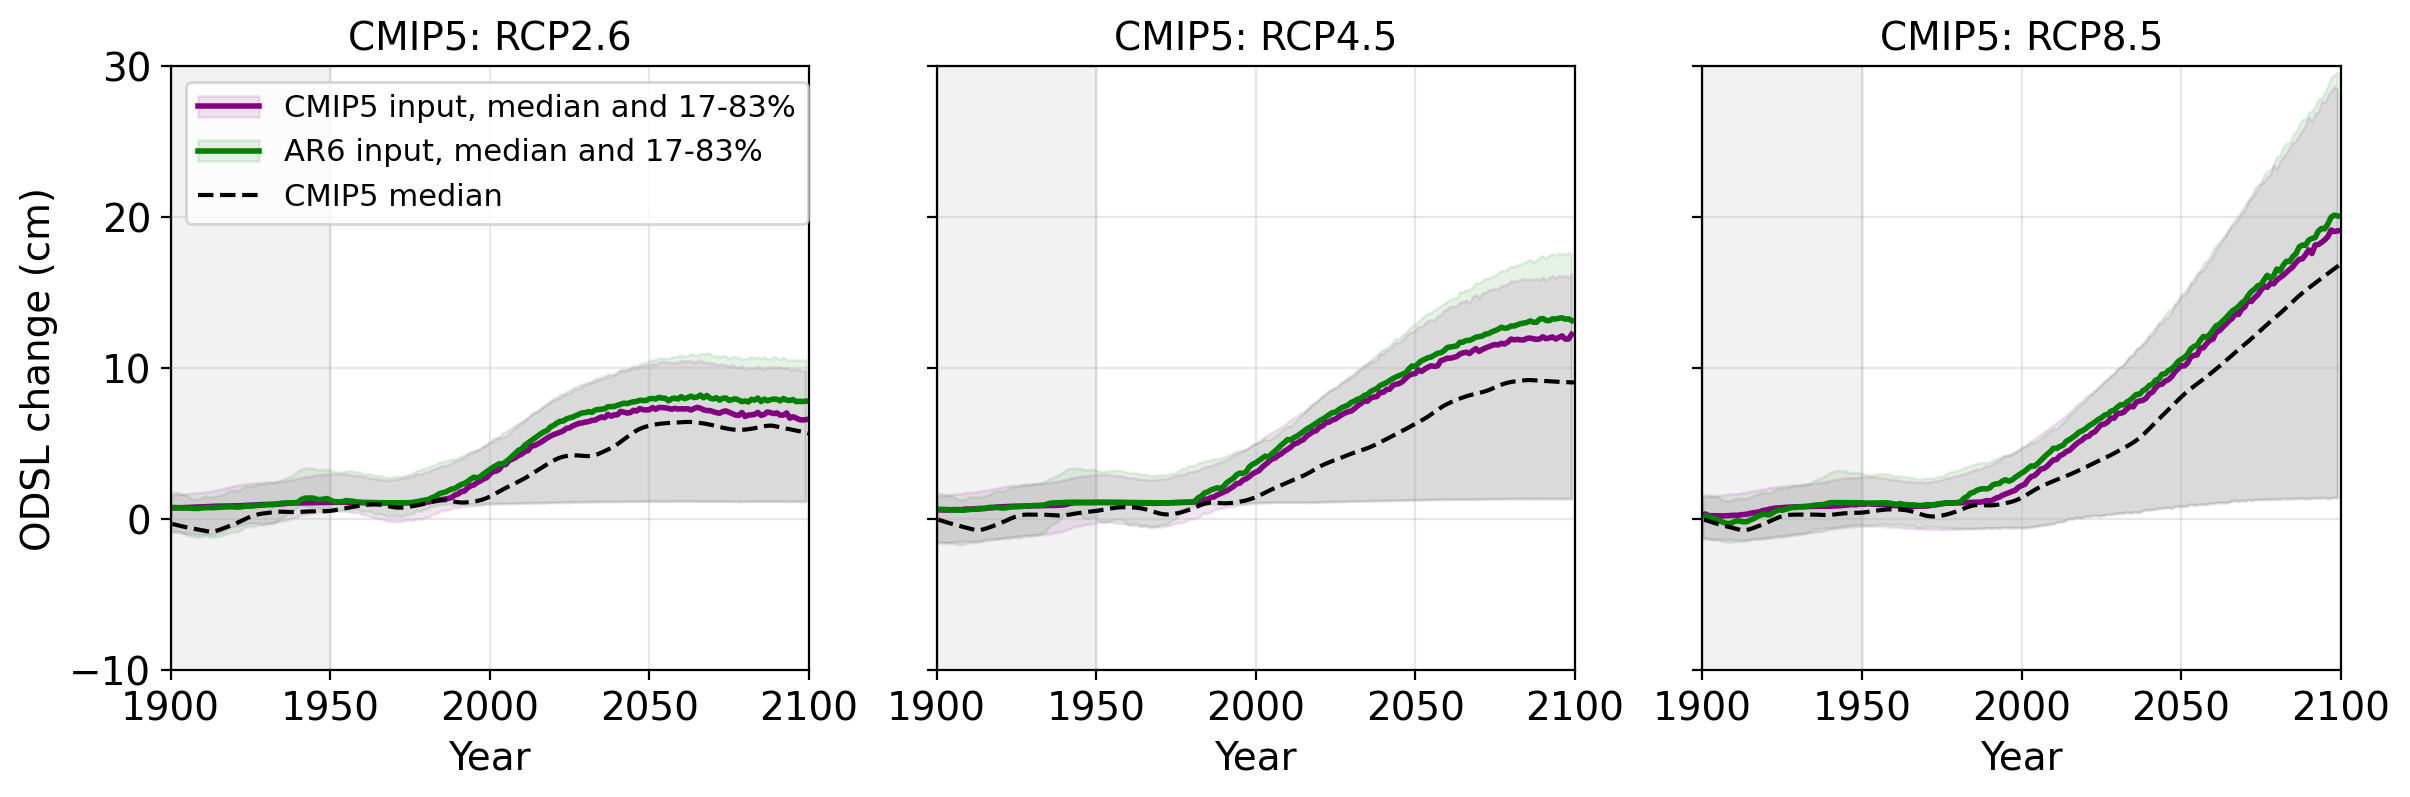

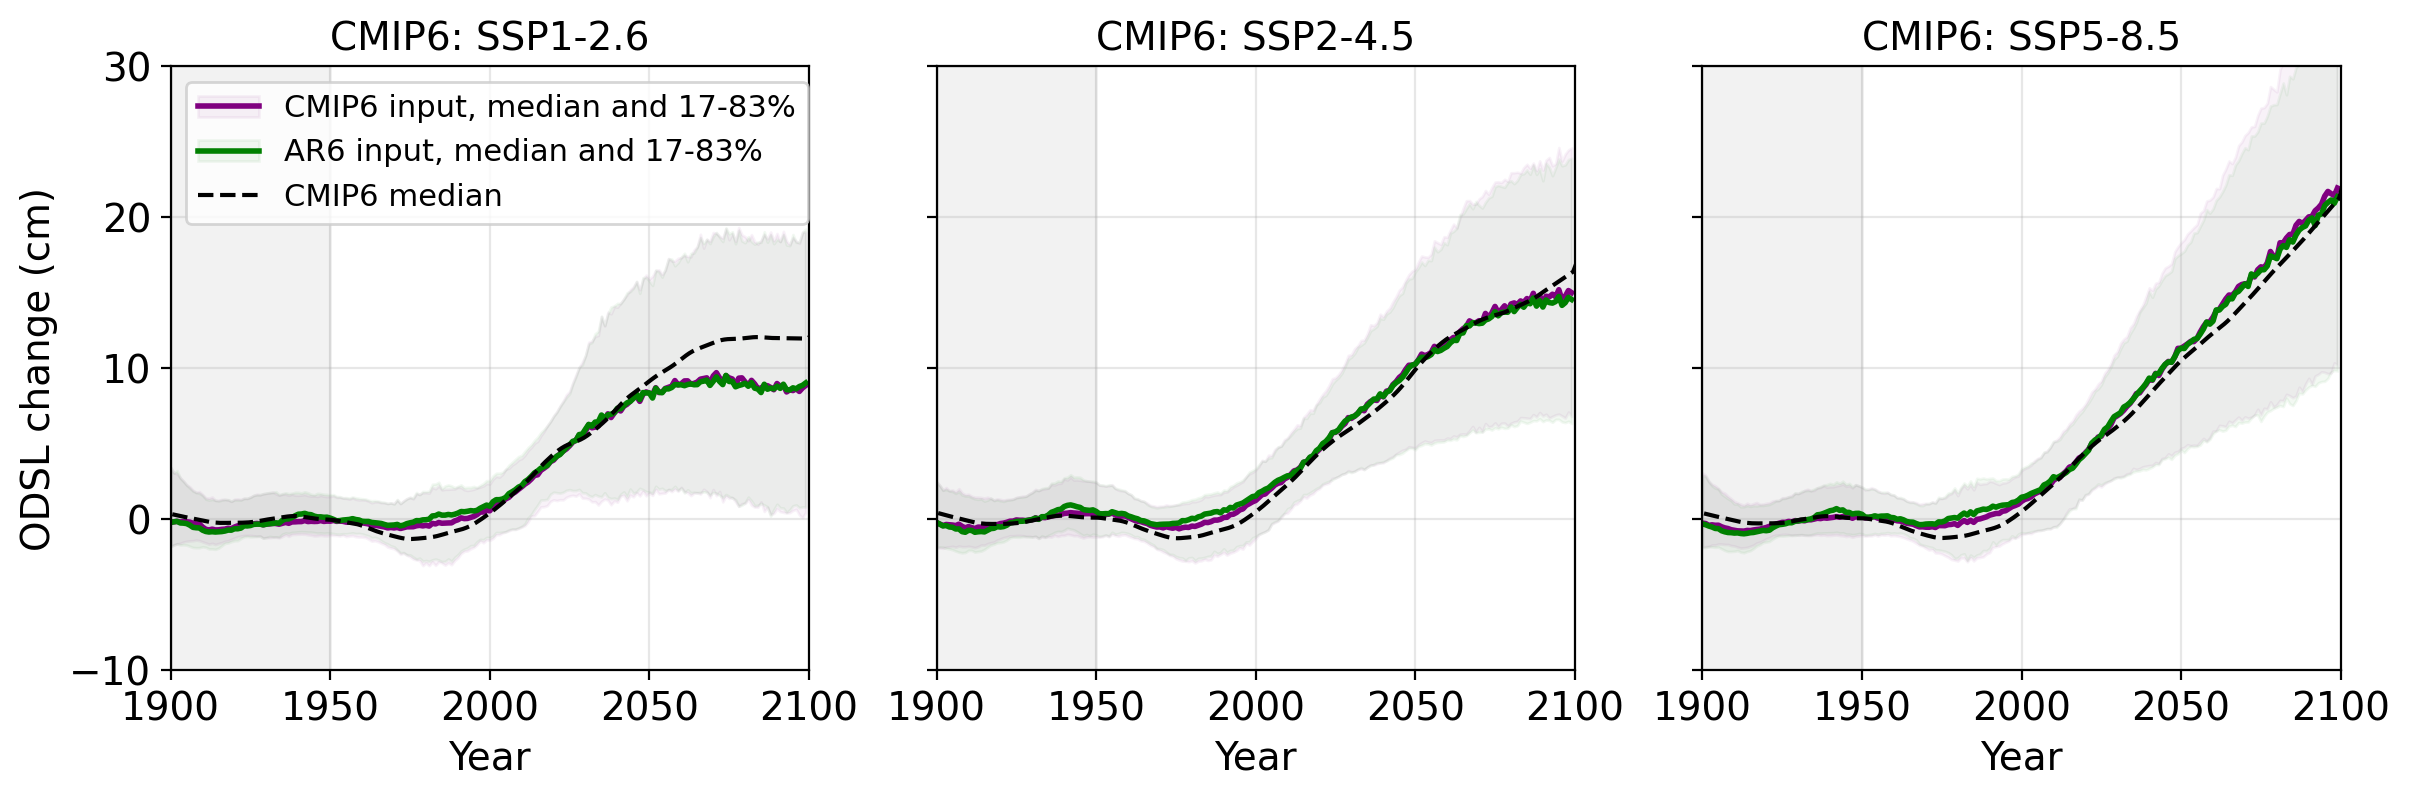

In [97]:
plot_Method2_compare_AR6_CMIP(data_C5, data_C6, CMIP5_DSL_CMIP_G, CMIP6_DSL_CMIP_G, CMIP5_DSL_AR6, CMIP6_DSL_AR6, varx1_ch, varx2_ch, True)

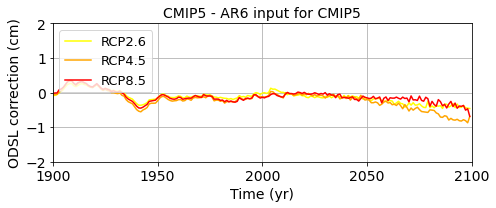

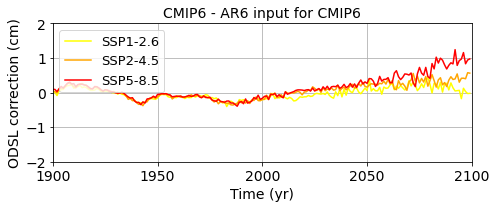

In [99]:
sces5 = ['RCP2.6','RCP4.5','RCP8.5']
sces6 = ['SSP1-2.6','SSP2-4.5','SSP5-8.5']

plot_Method2_differences(CMIP5_DSL_CMIP_G, CMIP5_DSL_AR6,'CMIP5 - AR6 input for CMIP5', sces5, saveplots = True)
plot_Method2_differences(CMIP6_DSL_CMIP_G, CMIP6_DSL_AR6,'CMIP6 - AR6 input for CMIP6', sces6, saveplots = True)


plot_Method2_differences(CMIP5_DSL_CMIP, CMIP5_DSL_AR6,'CMIP - AR6 input for CMIP5', sces5, saveplots = None)
plot_Method2_differences(CMIP6_DSL_CMIP, CMIP6_DSL_AR6,'CMIP - AR6 input for CMIP6', sces6, saveplots = None)

sces = ['*2.6','*4.5','*8.5']
plot_Method2_differences(CMIP5_DSL_CMIP, CMIP6_DSL_CMIP,'CMIP-C5 - CMIP-C6', sces, saveplots = None)
plot_Method2_differences(CMIP5_DSL_AR6, CMIP6_DSL_AR6,'AR6-C5 - AR6-C6', sces, saveplots = None)

# BARPLOTS

In [101]:
def edit_scen_name(sce):
    '''Convert name from rcp85 to RCP8.5 and ssp585 to SSP5-8.5'''
    
    if 'rcp' in sce:
        sce_out = f'{sce[0:3].upper()}{sce[3]}.{sce[4]}'
        if '-c' in sce:
            sce_out = f'{sce[0:3].upper()}{sce[3]}.{sce[4]}-C'
        elif '-a' in sce:
            sce_out = f'{sce[0:3].upper()}{sce[3]}.{sce[4]}-A'
    elif 'ssp' in sce:
        sce_out = f'{sce[0:3].upper()}{sce[3]}-{sce[4]}.{sce[5]}'
        if '-c' in sce:
            sce_out = f'{sce[0:3].upper()}{sce[3]}-{sce[4]}.{sce[5]}-C'
        elif '-a' in sce:
            sce_out = f'{sce[0:3].upper()}{sce[3]}-{sce[4]}.{sce[5]}-A'
    else:
        print('Scenario name not recognised')
    return sce_out

In [102]:
def make_barplot(DSL_proj, mip, perc, start_year, end_year, cor = None):
    
    
    # Construct dataframe with DSLs for each scenario

    st = start_year - 1900
    en = end_year - 1900
    
    if mip == 'cmip5':
        sces_m = ['rcp26','rcp45','rcp85']
        if cor == 'CMIP':
            sces_m = ['rcp26-c','rcp45-c','rcp85-c']
        elif cor == 'AR6':
            sces_m = ['rcp26-a','rcp45-a','rcp85-a']
    elif mip == 'cmip6':
        sces_m = ['ssp126','ssp245','ssp585'] 
        if cor == 'CMIP':
            sces_m = ['ssp126-c','ssp245-c','ssp585-c']
        elif cor == 'AR6':
            sces_m = ['ssp126-a','ssp245-a','ssp585-a']
               
    col = [f'{mip.upper()} Scenario']
    
    for p in perc:
        col.append(f'Percentile: {p}')
    summary_df = pd.DataFrame(columns=col)
        
    for i in range(3):
        DSL_av = DSL_proj[i][:,st:en].mean(axis=1)
        
         # Append the percentile scores to a list val
        val = [edit_scen_name(sces_m[i])]
        for p in perc:
            val.append(round(np.quantile(DSL_av,p/100),1))
        summary_df.loc[i] = val

    summary_df.set_index(col[0], inplace=True)
    summary_df = summary_df.T
        
    return summary_df

In [106]:
def summary_fig_and_table(ax, df, colors=None, vlines=False):
    
    mi = 0.6 # Max color intensity
    
    # Get some pastel shades for the colors
    if not(colors):
        colors = plt.cm.Greens(np.linspace(0, mi, len(df.index)))
        rowColours = colors
        
        # Expand the array
        ones = np.ones(len(df.columns))
        colors = colors[np.newaxis,:,:] * ones[:, np.newaxis, np.newaxis]
        
    elif colors=='alternate':
        colors1 = plt.cm.Greens(np.linspace(0, mi, len(df.index)))
        colors2 = plt.cm.Purples(np.linspace(0, mi, len(df.index)))
        colors = np.zeros([len(df.columns), len(df.index), 4])
        colors[::2] = colors2
        colors[1::2] = colors1
        
        rowColours = plt.cm.Greys(np.linspace(0, mi, len(df.index)))

    # Start from white color
    colors[:,0,:] = 0
    
    index = np.arange(len(df.columns))
    bar_width = 0.6

    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(df.columns))

    # Plot bars and create text labels for the table
    cell_text = []
    for row in range(len(df.index)):
        ax.bar(index, 
               df.iloc[row]-y_offset, 
               bar_width, 
               bottom=y_offset, 
               color=colors[:,row,:])
        
        y_offset = df.iloc[row]
        cell_text.append(['%1.1f' % x for x in df.iloc[row]])
    
    ax.set_xlim(-0.5,index[-1]+0.5)
    ax.set_ylim(-15,45)
    
    # Add a table at the bottom of the axes
    table= ax.table(cellText=cell_text[::-1],
             rowLabels=df.index[::-1],
             rowColours=rowColours[::-1],
             colColours=colors[:,2,:],
             colLabels= df.columns,
             loc='bottom')
    table.set_fontsize(8)
    ax.set_xticks([])
    
    if vlines:
        xcoords = index[0:]+1.5
        xcoords = xcoords[::2]
        for xc in xcoords:
            plt.axvline(x=xc, color='black', linewidth=0.5, linestyle='--')
    
    return ax

In [110]:
def plot_barplots(pandadf, new_col_names, varx_ch, comparison, saveplots=None):
    
    pandadf = pandadf.reindex(columns = new_col_names)

    fig, ax = plt.subplots(1,figsize=(7,4),dpi=100)
    ax = summary_fig_and_table(ax, pandadf, colors='alternate', vlines=True)
    ax.set_ylabel('ODSL change [cm]');

    plt.subplots_adjust(left=0.22, bottom=0.24)
    if saveplots==True:
        plt.savefig(savepath+f'Barplot_{varx_ch}_{comparison}.pdf',dpi=dpi)

In [108]:
DSL_proj5 = []
DSL_proj6 = []
for sces in ['ssp126', 'ssp245', 'ssp585']:
    newds5=select_models(data_C5.sel(scenario=sces), varx1_ch, varx2_ch, 'zos', 'model')[1]
    newds6=select_models(data_C6.sel(scenario=sces), varx1_ch, varx2_ch, 'zos', 'model')[1]
    DSL_proj5.append(newds5.zos.values)
    DSL_proj6.append(newds6.zos.values)


In [109]:
C5_CM = make_barplot(CMIP5_DSL_CMIP_G, 'cmip5', [5,17,50,83,95], 2081, 2101,'CMIP')
C5_AR = make_barplot(CMIP5_DSL_AR6, 'cmip5', [5,17,50,83,95], 2081, 2101,'AR6')
C6_CM = make_barplot(CMIP6_DSL_CMIP_G, 'cmip6', [5,17,50,83,95], 2081, 2101,'CMIP')
C6_AR = make_barplot(CMIP6_DSL_AR6, 'cmip6', [5,17,50,83,95], 2081, 2101,'AR6')

zos5 = make_barplot(DSL_proj5, 'cmip5', [5,17,50,83,95], 2081, 2101, cor = None)
zos6 = make_barplot(DSL_proj6, 'cmip6', [5,17,50,83,95], 2081, 2101, cor = None)

zo5_zo6 = pd.concat([zos5, zos6], axis=1)
zo5_AR5 = pd.concat([zos5, C5_AR], axis=1)
zo6_AR6 = pd.concat([zos6, C6_AR], axis=1)

CM5_AR5 = pd.concat([C5_CM, C5_AR], axis=1)
CM6_AR6 = pd.concat([C6_CM, C6_AR], axis=1)
CM5_CM6 = pd.concat([C5_CM, C6_CM], axis=1)
AR5_AR6 = pd.concat([C5_AR, C6_AR], axis=1)

## Plots in Thesis: Results with CMIP input vs. AR6 input for both ensembles

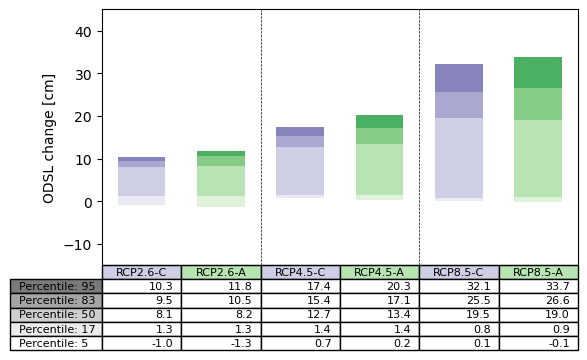

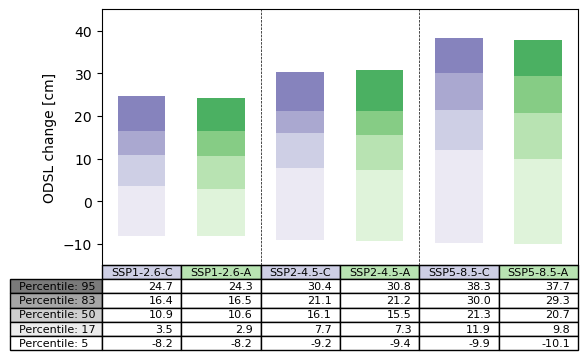

In [111]:
labs =  ['RCP2.6-C', 'RCP2.6-A', 'RCP4.5-C', 'RCP4.5-A', 'RCP8.5-C', 'RCP8.5-A']
plot_barplots(CM5_AR5, labs, 'AMOC', 'CM5_AR5', True)

labs = ['SSP1-2.6-C', 'SSP1-2.6-A', 'SSP2-4.5-C', 'SSP2-4.5-A', 'SSP5-8.5-C', 'SSP5-8.5-A'] 
plot_barplots(CM6_AR6, labs, 'AMOC', 'CM6_AR6', True)

### RAW zos DATA 

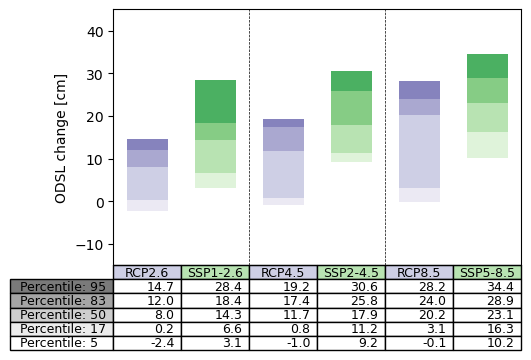

In [126]:
labs = ['RCP2.6', 'SSP1-2.6', 'RCP4.5', 'SSP2-4.5', 'RCP8.5', 'SSP5-8.5']
plot_barplots(zo5_zo6, labs, 'AMOC', 'zo5_zo6', None)

### CMIP5 vs. CMIP6 - CMIP input

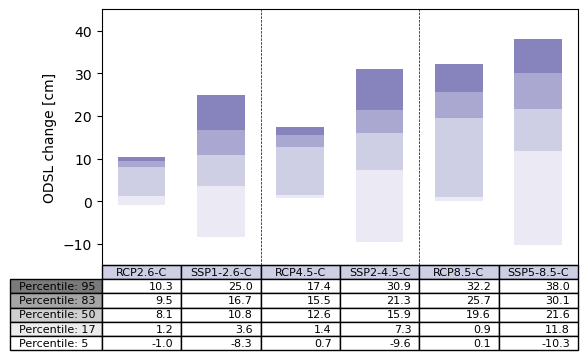

In [76]:
labs = ['RCP2.6-C', 'SSP1-2.6-C', 'RCP4.5-C', 'SSP2-4.5-C', 'RCP8.5-C', 'SSP5-8.5-C']
plot_barplots(CM5_CM6, labs, 'AMOC', 'CM5_CM6', None)

### CMIP5 vs. CMIP6 - AR6 input

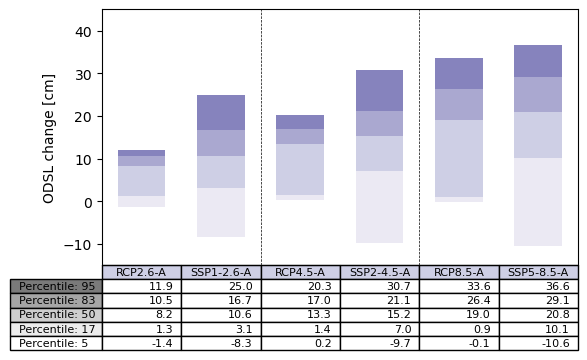

In [75]:
labs = ['RCP2.6-A','SSP1-2.6-A','RCP4.5-A','SSP2-4.5-A','RCP8.5-A','SSP5-8.5-A']
plot_barplots(AR5_AR6, labs, 'AMOC', 'AR5_AR6', None)